In [1]:
import torch
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
def t_comp(eps, delta):
    t = 8./(eps**2) * torch.log(2./delta)
    t = torch.floor(t + 1)
    return t

In [3]:
def c(p):
    fig = (2 + torch.floor(p))**(p + 1)
    if p > 1:
        nafig = torch.prod(torch.Tensor([abs((p - i + 1)/i) for i in range(1, int(p) + 1)]))
    else:
        nafig = torch.Tensor([1])
    return fig*nafig

In [4]:
def m_comp(c, p, eps, n):
    m = 7 * torch.pow(3 * c * n / (p * eps), 1 / p)
    return torch.floor(m + 1)

In [5]:
def beta(m, c, p):
    return c / p * torch.pow(m + 1.0, -p)

In [6]:
def hutch(X, p, m, t):
    y = torch.Tensor([0]).double()
    n = X.shape[0]
    for i in range(1, int(t.item()) + 1):
        g_i = torch.Tensor(np.random.binomial(1, 0.5, size=(n,))).double() * 2.0 - 1.0
        v_k = X @ g_i
        u_k = g_i @ v_k
        a_k = p
        S_i_k = a_k * u_k
        for k in range(2, int(m.item())+1):
            v_k = X@v_k
            u_k = g_i@v_k
            a_k = a_k * (p-(k-1))/k
            if torch.abs(a_k) < 1e-8:
                break
            S_i_k = S_i_k + (((-1)**(k-1)) * a_k) * u_k
        y += S_i_k
    y = y / t
    return y

In [7]:
def power_method(A, x0, num_iter):
    for it in range(num_iter):
        x0 = A @ x0
        x0 = x0 / torch.norm(x0)
        approx = (A @ x0)
        l = x0 @ approx
    return x0, l

In [8]:
def alpha(A, delta):
    n = A.shape[0]
    q = int(4.82 * np.log(1. / delta) + 1)
    t = int(0.5 * np.log(4 * n) + 1)
    max_lambda = 0
    for i in range(q):
        x0 = torch.Tensor(np.random.binomial(1, 0.5, size=(n,))).double() * 2.0 - 1.0
        x, l = power_method(A, x0, t)
        if l > max_lambda:
            max_lambda = l
    return max_lambda

In [9]:
def vova_bravo_without(A, p, eps, delta):
    n = A.shape[0]
    t = t_comp(eps, delta)
    c_p = c(p)
    m = m_comp(c_p, p, eps, n)
    b_m = beta(m, c_p, p)
    a = alpha(A, delta)
    print(t, m)
    return torch.pow(a, p) * torch.floor((1+b_m)*n - hutch(torch.eye(n).double() - A / a, p, m, t))

In [49]:
A = np.random.normal(size=(7000, 7000))
A = A.T @ A

In [41]:
p = torch.Tensor([5]).double()
eps = torch.Tensor([0.05]).double()
delta = torch.Tensor([0.05]).double()
A_t = torch.tensor(A, requires_grad=True)
A_f = A_t.double()
start = time.time()
schatten_vova_bravo = vova_bravo_without(A_f, p, eps, delta)
print(time.time() - start)

tensor([11805.], dtype=torch.float64) tensor([299.], dtype=torch.float64)
11.138583898544312


In [50]:
start = time.time()
schatten_true = compute_true_schatten(A, p.item())
print(time.time() - start)

209.84745001792908


In [55]:
sizes = [100, 500, 1000, 5000, 7000]
vova_times = [11, 17, 71, 882.5172441005707]
svd_times = [0.01, 0.33, 1, 81, 209]

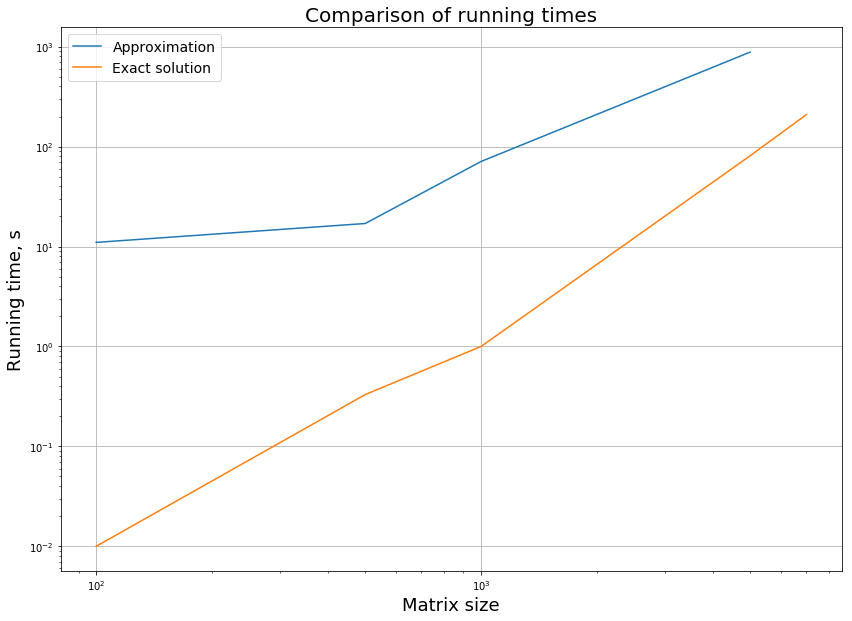

In [66]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(14, 10))
ax.set_title('Comparison of running times', fontsize=20)
ax.plot(sizes[:4], vova_times, label='Approximation')
ax.plot(sizes, svd_times, label='Exact solution')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Matrix size', fontsize=18)
ax.set_ylabel('Running time, s', fontsize=18)
ax.grid()
ax.legend(fontsize=14)

In [15]:
def compute_true_schatten(A, p):
    u, s, vh = np.linalg.svd(A)
    return np.power(s, p).sum()


def compute_schatten_grad(A, p):
    u, s, vh = np.linalg.svd(A)
    return u @ np.diag(np.power(s, p-1)) @ vh * p

def compute_schatten_grad_2(A, p):
    u, s, vh = np.linalg.svd(A)
    sp = np.power(np.power(s, p).sum(), 1/p)
    dS = u @ np.diag(np.power(s, p -1)/sp) @ vh
    return p * np.power(dS, p-1)

In [596]:
schatten_true = compute_true_schatten(A_new, p)

In [597]:
np.abs((schatten_vova_bravo.detach() - schatten_true) / schatten_true)

tensor([0.0158], dtype=torch.float64)

In [598]:
schatten_vova_bravo.backward()

In [599]:
A_t.grad

tensor([[ 0.8511, -1.4945,  0.6963,  ...,  0.4221, -2.5998,  0.6154],
        [-0.6515,  0.7739, -0.2859,  ..., -0.3538,  1.3965, -0.2185],
        [ 0.2475,  0.4586, -0.3903,  ...,  0.2001,  0.6700, -0.4281],
        ...,
        [ 0.4405, -0.9700,  0.4897,  ...,  0.1996, -1.6563,  0.4509],
        [-1.2020,  1.4430, -0.5358,  ..., -0.6406,  2.5859, -0.4073],
        [ 0.0611,  0.3439, -0.2506,  ...,  0.0664,  0.5383, -0.2643]],
       dtype=torch.float64)

In [588]:
schatten_vova_bravo

tensor([21.1299], dtype=torch.float64, grad_fn=<MulBackward0>)

In [602]:
grad = compute_schatten_grad_2(A_t.detach().numpy(), p.numpy())

In [603]:
np.linalg.norm(grad - A_t.grad.detach().numpy(), 2) / np.linalg.norm(grad, 2)

283351.7729720709

In [ ]:
np.linalg.norm(grad - A_t.grad.detach().numpy(), 2) / np.linalg.norm(grad, 2)

In [530]:
sing = power_method(A_t, A_t.detach()[0], 50)[1]

In [532]:
sing.backward()

In [533]:
A_t.grad

tensor([[ 0.0076, -0.0507, -0.0040,  ..., -0.0301,  0.1557, -0.0508],
        [-0.3627,  0.5163, -0.5008,  ..., -0.2777, -0.9825, -0.3389],
        [-0.2340,  0.1943, -0.3119,  ..., -0.2051, -0.3023, -0.3021],
        ...,
        [ 0.2119, -0.2561,  0.2636,  ...,  0.1645,  0.4483,  0.1997],
        [ 0.0629, -0.1645,  0.0162,  ..., -0.0891,  0.4840, -0.1208],
        [-0.3227,  0.3134, -0.4170,  ..., -0.2542, -0.5431, -0.3636]],
       dtype=torch.float64)

In [537]:
u[:, 0:1] @ u[:, 0:1].T

array([[ 0.00073753,  0.00253306,  0.00031008, ..., -0.00048976,
         0.00030083,  0.00047199],
       [ 0.00253306,  0.00869986,  0.00106499, ..., -0.00168209,
         0.00103322,  0.00162107],
       [ 0.00031008,  0.00106499,  0.00013037, ..., -0.00020591,
         0.00012648,  0.00019844],
       ...,
       [-0.00048976, -0.00168209, -0.00020591, ...,  0.00032523,
        -0.00019977, -0.00031343],
       [ 0.00030083,  0.00103322,  0.00012648, ..., -0.00019977,
         0.00012271,  0.00019252],
       [ 0.00047199,  0.00162107,  0.00019844, ..., -0.00031343,
         0.00019252,  0.00030206]])

In [539]:
u[0:1, :].T @ u[0:1, :]

array([[ 7.37526677e-04,  1.28944436e-03, -1.19623900e-03, ...,
        -3.51120393e-03, -2.69281427e-04,  8.93925164e-04],
       [ 1.28944436e-03,  2.25438184e-03, -2.09142756e-03, ...,
        -6.13876382e-03, -4.70794381e-04,  1.56288144e-03],
       [-1.19623900e-03, -2.09142756e-03,  1.94025217e-03, ...,
         5.69503340e-03,  4.36763785e-04, -1.44991113e-03],
       ...,
       [-3.51120393e-03, -6.13876382e-03,  5.69503340e-03, ...,
         1.67160774e-02,  1.28199024e-03, -4.25578307e-03],
       [-2.69281427e-04, -4.70794381e-04,  4.36763785e-04, ...,
         1.28199024e-03,  9.83184595e-05, -3.26384727e-04],
       [ 8.93925164e-04,  1.56288144e-03, -1.44991113e-03, ...,
        -4.25578307e-03, -3.26384727e-04,  1.08348921e-03]])

In [606]:
def build_matrix(size, magnitude):
    A = np.random.normal(size=(size, size))
    u, s, vh = np.linalg.svd(A)
    return  u @ np.diag( magnitude * s / np.max(s)) @ u.T

In [622]:
size = 200
magnitudes = np.concatenate([10.0**(np.arange(-5, 0)), 5 * 10.0**(np.arange(-4, 0)), 10.0**(np.arange(0, 5)), 5 * 10.0**(np.arange(0, 4)), ])
magnitudes.sort()
for magnitude in magnitudes:
    A = build_matrix(size, magnitude)
    A_t = torch.tensor(A_new)
    schatten_vova_bravo = vova_bravo_without(A_f, p, eps, delta)
    schatten_true = compute_true_schatten(A_new, p)
    error = np.abs((schatten_vova_bravo.detach() - schatten_true) / schatten_true)
    errors.append(error)
    print(magnitude)

tensor([11805.], dtype=torch.float64) tensor([343.], dtype=torch.float64)
1e-05
tensor([11805.], dtype=torch.float64) tensor([343.], dtype=torch.float64)
0.0001
tensor([11805.], dtype=torch.float64) tensor([343.], dtype=torch.float64)
0.0005
tensor([11805.], dtype=torch.float64) tensor([343.], dtype=torch.float64)
0.001
tensor([11805.], dtype=torch.float64) tensor([343.], dtype=torch.float64)
0.005
tensor([11805.], dtype=torch.float64) tensor([343.], dtype=torch.float64)
0.01
tensor([11805.], dtype=torch.float64) tensor([343.], dtype=torch.float64)
0.05
tensor([11805.], dtype=torch.float64) tensor([343.], dtype=torch.float64)
0.1
tensor([11805.], dtype=torch.float64) tensor([343.], dtype=torch.float64)
0.5


Text(0,0.5,'Error')

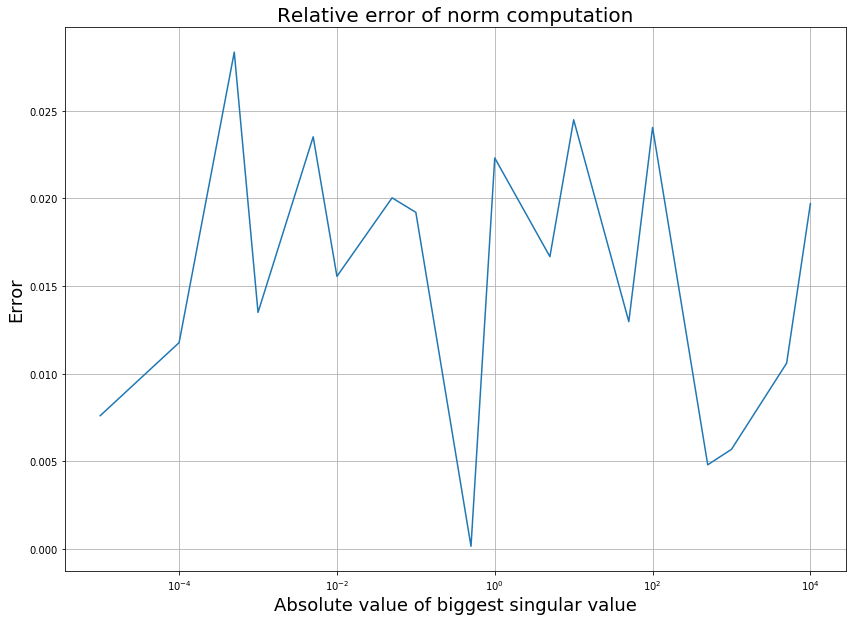

In [629]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(14, 10), )
ax.set_title('Relative error of norm computation', fontsize=20)
ax.plot(magnitudes, errors)
ax.set_xscale('log')
ax.grid()
ax.set_xlabel('Absolute value of biggest singular value', fontsize=18)
ax.set_ylabel('Error', fontsize=18)